In [247]:
import numpy as np
import pandas as pd
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [31]:
file_path = 'database_2c.xlsx'
data = pd.read_excel(file_path)

In [32]:
y_1 = to_categorical(data['y_1'], num_classes=8)
y_2 = to_categorical(data['y_2'] - 1, num_classes=7)  # 如果y_2是从1开始的，需要减去1


In [33]:
# 分割特征和标签
X = data[['x_1', 'x_2', 'x_3']].values  # 输入特征：光电流值


In [34]:
print(X.shape, y_1.shape, y_2.shape)

(560, 3) (560, 8) (560, 7)


In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [174]:
X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X_scaled, y_1, y_2, test_size=0.2, random_state=42
)

In [232]:
inputs = Input(shape=(X_train.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(inputs)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
# 添加Dropout
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.2)(x)
x_1 = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x_1)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(x)
# add batch normalization


y_1_output = Dense(8, activation='softmax', name='y_1_output', kernel_regularizer=l2(0.001))(x_1)
y_2_output = Dense(7, activation='softmax', name='y_2_output')(x)


model = Model(inputs=inputs, outputs=[y_1_output, y_2_output])



In [233]:

model.compile(optimizer='Adamax',
              loss={'y_1_output': 'categorical_crossentropy',
                    'y_2_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

In [ ]:
# define the cost of the model

In [250]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [255]:
# train the model
model.fit(X_train, {'y_1_output': y_1_train, 'y_2_output': y_2_train},
          epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


12/12 [==============================] - 0s 12ms/step - loss: 0.8033 - y_1_output_loss: 0.4761 - y_2_output_loss: 0.1204 - y_1_output_accuracy: 0.7905 - y_2_output_accuracy: 0.9525 - val_loss: 1.6277 - val_y_1_output_loss: 1.1686 - val_y_2_output_loss: 0.2524 - val_y_1_output_accuracy: 0.5556 - val_y_2_output_accuracy: 0.8889
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 0.8545 - y_1_output_loss: 0.5071 - y_2_output_loss: 0.1406 - y_1_output_accuracy: 0.7682 - y_2_output_accuracy: 0.9441 - val_loss: 1.7185 - val_y_1_output_loss: 1.1852 - val_y_2_output_loss: 0.3266 - val_y_1_output_accuracy: 0.5667 - val_y_2_output_accuracy: 0.9000
Epoch 3/100
12/12 [==============================] - 0s 8ms/step - loss: 0.8098 - y_1_output_loss: 0.4809 - y_2_output_loss: 0.1220 - y_1_output_accuracy: 0.7961 - y_2_output_accuracy: 0.9358 - val_loss: 1.6193 - val_y_1_output_loss: 1.1585 - val_y_2_output_loss: 0.2539 - val_y_1_output_accuracy: 0.5444 - val_y_2_output_accuracy: 0

In [249]:
# train the model
model.fit(X_train, {'y_1_output': y_1_train, 'y_2_output': y_2_train},
          epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

NameError: name 'early_stopping' is not defined

In [177]:
losses, y_1_loss, y_2_loss, y_1_acc, y_2_acc = model.evaluate(X_test, [y_1_test, y_2_test])
print(f'Test accuracy for y_1: {y_1_acc}')
print(f'Test accuracy for y_2: {y_2_acc}')

4/4 [==============================] - 0s 2ms/step - loss: 2.7060 - y_1_output_loss: 1.6157 - y_2_output_loss: 0.8858 - y_1_output_accuracy: 0.5089 - y_2_output_accuracy: 0.8661
Test accuracy for y_1: 0.5089285969734192
Test accuracy for y_2: 0.8660714030265808


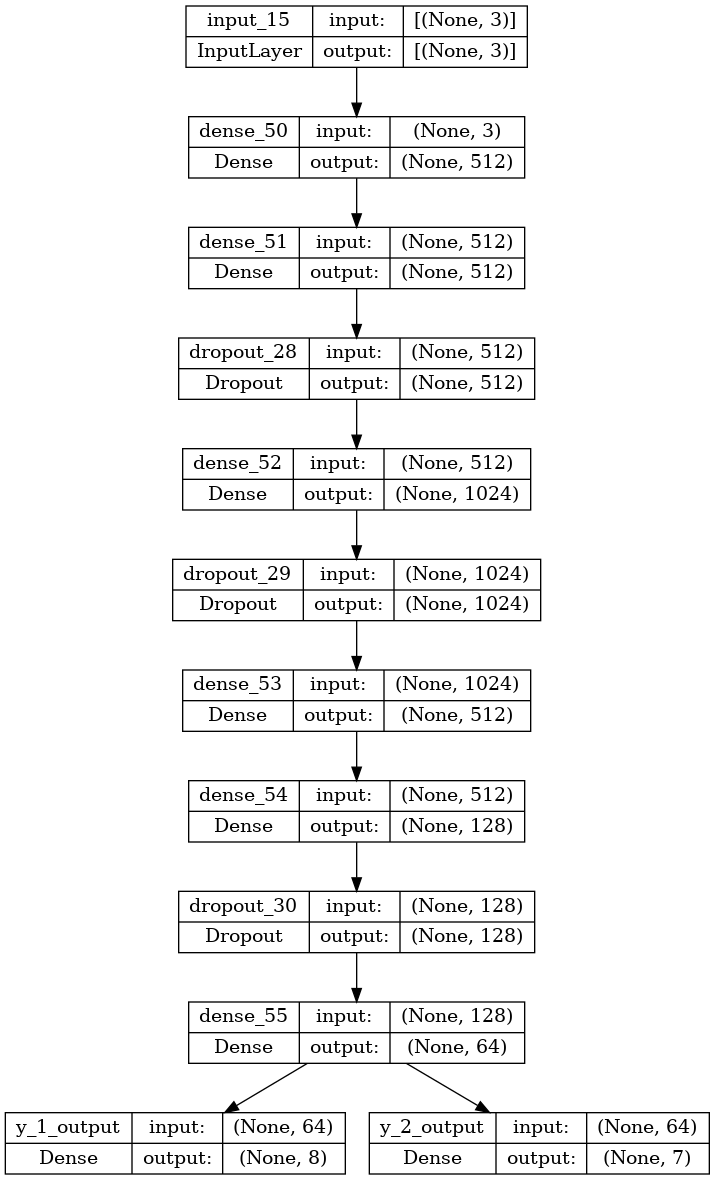

In [178]:
# draw the landscape of the model
tf.keras.utils.plot_model(model, show_shapes=True)


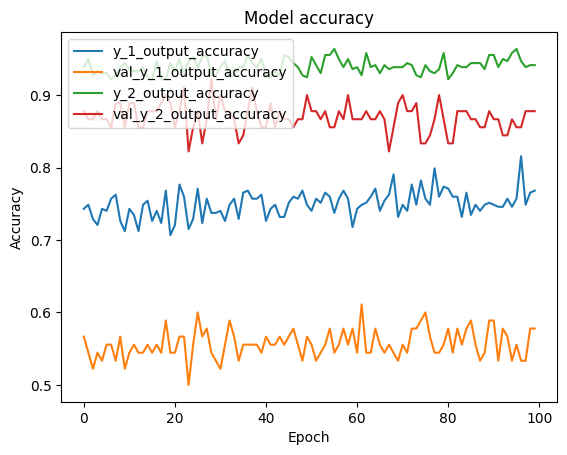

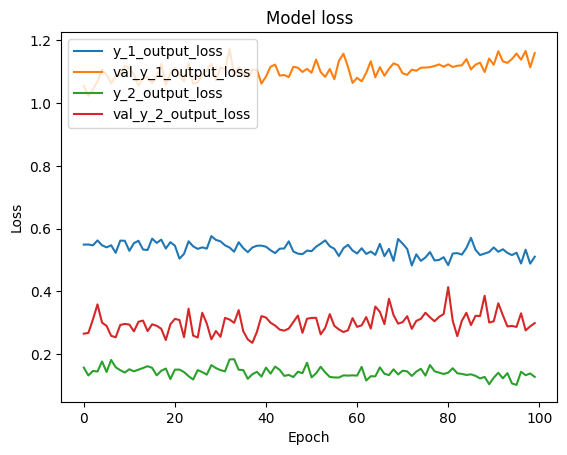

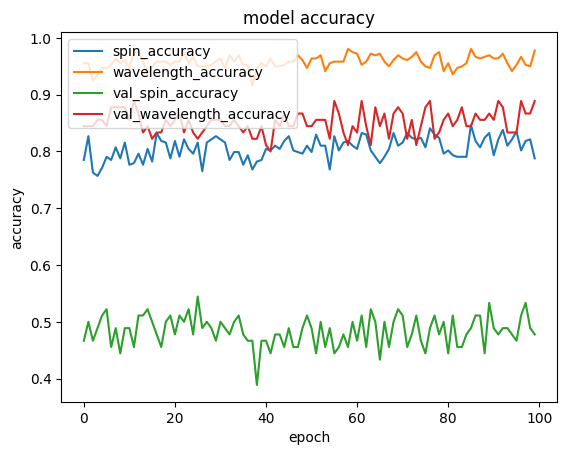

In [166]:
# beautify the plot
plt.plot(history['y_1_output_accuracy'], label='spin_accuracy')
plt.plot(history['y_2_output_accuracy'], label='wavelength_accuracy')
plt.plot(history['val_y_1_output_accuracy'], label='val_spin_accuracy')
plt.plot(history['val_y_2_output_accuracy'], label='val_wavelength_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


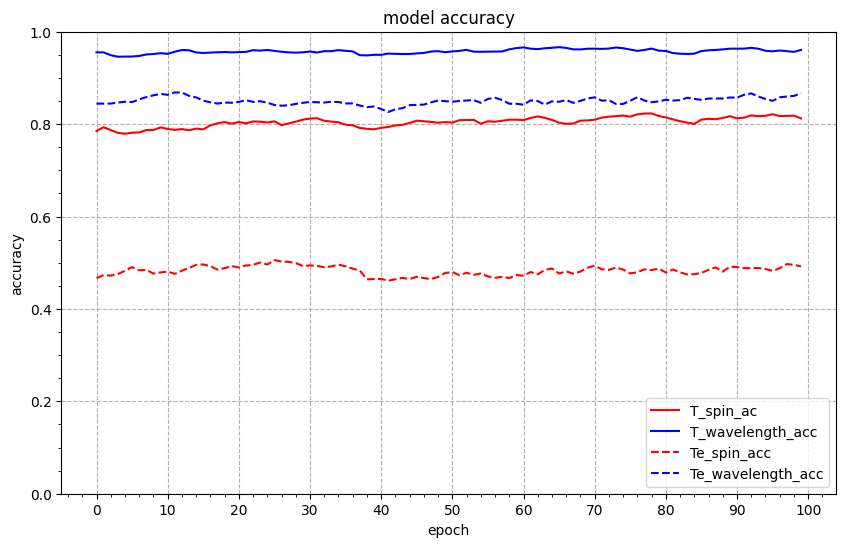

In [240]:
# smooth the plot 
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
# set the figure size
plt.figure(figsize=(10, 6))
plt.plot(smooth_curve(history['y_1_output_accuracy']), label='T_spin_ac', color='red', linestyle='-')
plt.plot(smooth_curve(history['y_2_output_accuracy']), label='T_wavelength_acc', color='blue', linestyle='-')
plt.plot(smooth_curve(history['val_y_1_output_accuracy']), label='Te_spin_acc', color='red', linestyle='--')
plt.plot(smooth_curve(history['val_y_2_output_accuracy']), label='Te_wavelength_acc', color='blue', linestyle='--')
# y axis from 0 to 1,ticks 0.1
plt.yticks(np.arange(0, 1.1, 0.2))
# set the small ticks to y axis only
plt.minorticks_on()
plt.xticks(np.arange(0, 101, 10))
# add the grid line,dash line
plt.grid(True, linestyle='--')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

In [152]:
# svae the plot to a file
plt.savefig('accuracy.png')

<Figure size 640x480 with 0 Axes>